In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import TimeSeriesSplit


In [ ]:
from google.colab import files
uploaded = files.upload()

[I 2024-08-18 04:21:36,650] A new study created in memory with name: no-name-6e75f2c0-c343-449c-a2bf-8967fd1d8065
[I 2024-08-18 04:21:36,990] Trial 0 finished with value: 0.5729386747803153 and parameters: {'C': 84.09590274880513, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5729386747803153.
[I 2024-08-18 04:21:38,128] Trial 1 finished with value: 0.58897823006136 and parameters: {'C': 14.625495279707476, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.58897823006136.
[I 2024-08-18 04:21:40,757] Trial 2 finished with value: 0.5742114487420047 and parameters: {'C': 86.17482933045923, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.58897823006136.
[I 2024-08-18 04:21:41,124] Trial 3 finished with value: 0.5748051688284411 and parameters: {'C': 93.88376839106957, 'solver': 'liblinear'}. Best is trial 1 with value: 0.58897823006136.
[I 2024-08-18 04:21:44,492] Trial 4 finished with value: 0.5738652091987673 and parameters: {'C': 72.90757389088569, 'solver': 'lbfgs'}. Best is 

Best hyperparameters: {'C': 3.0429358854050066, 'solver': 'lbfgs'}
Evaluation metrics: {'Accuracy': 0.8183599216344808, 'Precision': 0.8257191201353637, 'Recall': 0.811529933481153, 'F1 Score': 0.818563041655018, 'ROC AUC': 0.8976675787365304}


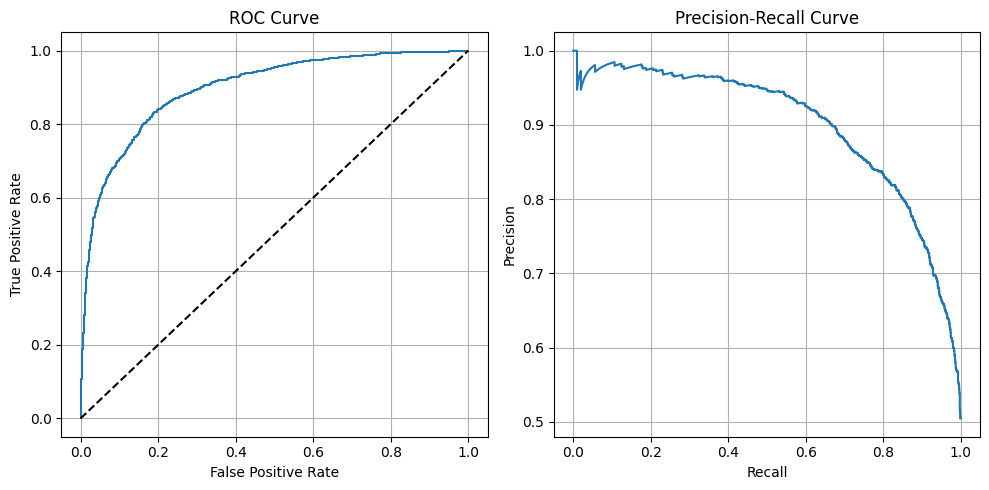

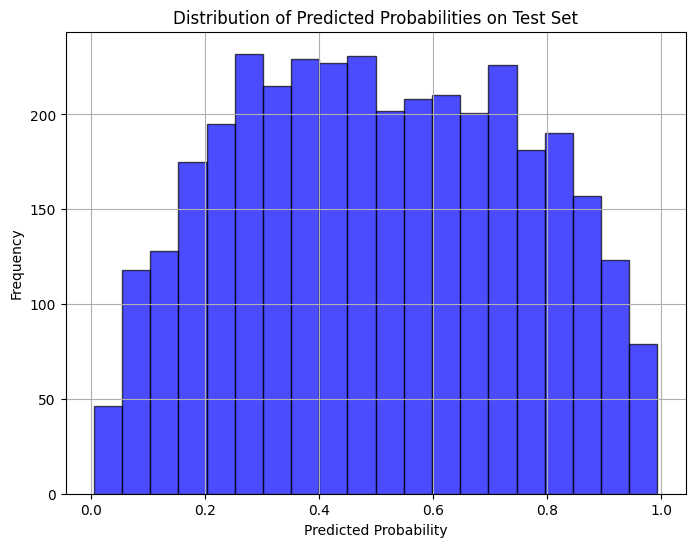

Granular probabilities saved to: /content/granular_probabilities.csv


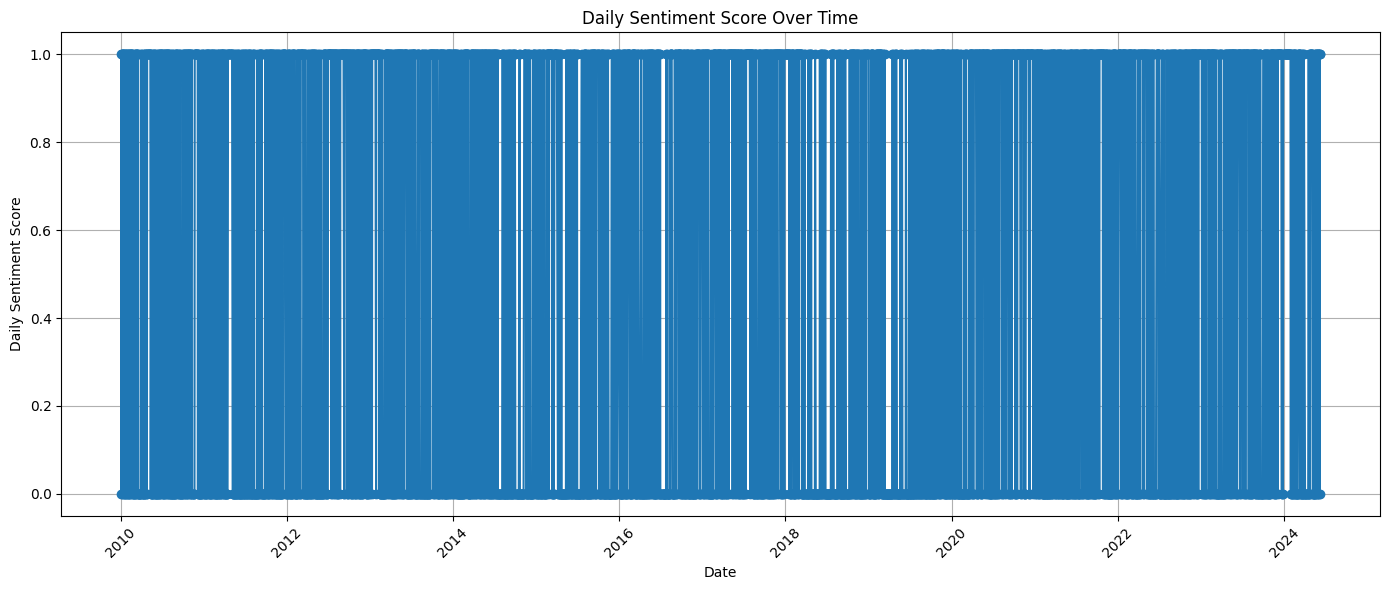

In [ ]:

def load_and_preprocess_news_data(file_path):
    # Load the CSV file
    news_data = pd.read_csv(file_path)

    # Convert the 'Date' column to datetime using the correct format
    news_data['Date'] = pd.to_datetime(news_data['Date'], format='%d/%m/%Y', errors='coerce')

    # Drop rows with invalid date formats if any
    news_data.dropna(subset=['Date'], inplace=True)

    # Sort the data by the 'Date' column
    news_data.sort_values('Date', inplace=True)

    return news_data

def prepare_news_data(news_data):
    # Initialize TF-IDF Vectorizer and prepare feature matrix and labels
    text_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    text_features = text_vectorizer.fit_transform(news_data['text']).toarray()
    target_labels = news_data['label'].values
    return text_features, target_labels, text_vectorizer

def split_train_val_test(features, labels, train_val_ratio=0.85):
    # Calculate the index where the training and validation data ends
    train_val_size = int(len(features) * train_val_ratio)

    # Split the data into training/validation and testing sets
    X_train_val = features[:train_val_size]
    X_test = features[train_val_size:]
    y_train_val = labels[:train_val_size]
    y_test = labels[train_val_size:]

    return X_train_val, X_test, y_train_val, y_test

def optimize_model_with_timeseriescv(X, y):
    # Optimize model hyperparameters using TimeSeriesSplit and Optuna
    tscv = TimeSeriesSplit(n_splits=5)

    def objective(trial):
        params = {
            'C': trial.suggest_float('C', 1e-4, 1e2),
            'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
            'penalty': 'l2'
        }
        f1_scores = []

        for train_index, val_index in tscv.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            classifier = LogisticRegression(**params, max_iter=1000)
            classifier.fit(X_train, y_train)
            pred = classifier.predict(X_val)
            f1_scores.append(f1_score(y_val, pred))

        # Return the average F1 score across all splits
        return np.mean(f1_scores)

    hyperparam_optimization = optuna.create_study(direction='maximize')
    hyperparam_optimization.optimize(objective, n_trials=50)
    best_params = hyperparam_optimization.best_params
    print(f'Best hyperparameters: {best_params}')
    return best_params

def plot_evaluation_curves(y_true, y_scores):
    # Plot ROC and Precision-Recall Curves
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_probability_distribution(probabilities):
    # Plot histogram of predicted probabilities
    plt.figure(figsize=(8, 6))
    plt.hist(probabilities, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities on Test Set')
    plt.grid(True)
    plt.show()

# Main script to load news data and train model
file_path = 'financial_data.csv'  # Define the file path
news_data = load_and_preprocess_news_data(file_path)  # Load and preprocess the data
X, y, text_vectorizer = prepare_news_data(news_data)

# Optimize model using TimeSeriesSplit cross-validation
best_params = optimize_model_with_timeseriescv(X, y)

# Train the final model with the best parameters on the full dataset
classifier = LogisticRegression(**best_params, max_iter=1000)
classifier.fit(X, y)

# Evaluate on the entire dataset (or on a separate test set if available)
predictions = classifier.predict(X)
probabilities = classifier.predict_proba(X)[:, 1]
evaluation_scores = {
    'Accuracy': accuracy_score(y, predictions),
    'Precision': precision_score(y, predictions),
    'Recall': recall_score(y, predictions),
    'F1 Score': f1_score(y, predictions),
    'ROC AUC': roc_auc_score(y, probabilities)
}

# Display metrics for the dataset
print(f"Evaluation metrics: {evaluation_scores}")

# Plot evaluation curves
plot_evaluation_curves(y, probabilities)

# Plot probability distribution
plot_probability_distribution(probabilities)

# Calculate and plot daily sentiment score over time
news_data['predicted_prob'] = classifier.predict_proba(text_vectorizer.transform(news_data['text']).toarray())[:, 1]
news_data['predicted_sentiment'] = (news_data['predicted_prob'] >= 0.5).astype(int)

# Save the granular probabilities along with the Date and text columns (if needed)
granular_probabilities_path = '/content/granular_probabilities.csv'
news_data[['Date', 'text', 'predicted_prob']].to_csv(granular_probabilities_path, index=False)

# Optional: Print confirmation message
print(f'Granular probabilities saved to: {granular_probabilities_path}')

daily_sentiment = news_data.groupby('Date')['predicted_sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Daily Sentiment Score']

plt.figure(figsize=(14, 6))
plt.plot(daily_sentiment['Date'], daily_sentiment['Daily Sentiment Score'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Daily Sentiment Score')
plt.title('Daily Sentiment Score Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
